# EBM 1D latitudinal (climlab)

Notebook en construcción.

In [3]:
# EBM 1D latitudinal (climlab)

#Modelo de balance de energía latitudinal con ciclo estacional.

#Este notebook permite ejecutar un EBM 1D, explorar su estado estacionario estacional
#y analizar perfiles latitudinales y ciclos estacionales de temperatura superficial.

#**Instrucciones:**
#1. Ejecutar todas las celdas en orden.
#2. Modificar solo los parámetros indicados cuando se solicite.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
import warnings

# Silence harmless numerical warnings
warnings.filterwarnings("ignore", message="invalid value encountered in arccos")
warnings.filterwarnings("ignore", message="Cannot import and initialize compiled Fortran extension*")
warnings.filterwarnings("ignore", message="Cannot import EmanuelConvection*")
warnings.filterwarnings("ignore", message="Cannot import SimplifiedBettsMiller*")

print("numpy:", np.__version__)
print("climlab:", climlab.__version__)

numpy: 2.2.6
climlab: 0.9.1


In [19]:
# ==========================
# Parameters (editable)
# ==========================

nyears = 20
F = 0.0

ice_albedo_feedback = True   # SOLO afecta al diagnóstico (Figura C)


# Dynamic ice–albedo feedback (ON/OFF)
ice_albedo_dynamic = True

# Base (ice-free) smooth albedo pattern
a0 = 0.33
a2 = 0.25

# Ice parameters
aice = 0.60
Tf = 0.0        # °C
deltaT = 2.0    # °C  (transición más brusca -> más no linealidad; prueba 1–5)


In [20]:

from climlab.process.process import Process

def p2_albedo(lat_deg, a0, a2):
    x = np.sin(np.deg2rad(lat_deg))
    P2 = 0.5 * (3*x**2 - 1)
    return a0 + a2 * P2

class DynamicIceAlbedo(Process):
    def __init__(self, state, a0, a2, aice, Tf, deltaT, timestep):
        super().__init__(state=state)

        # Required by climlab TimeDependentProcess bookkeeping
        self.time_type = 'diagnostic'
        self.timestep = timestep
        self.time = {'active_now': False, 'steps': 0}

        self.a0 = a0
        self.a2 = a2
        self.aice = aice
        self.Tf = Tf
        self.deltaT = deltaT

        self.lat_points = self.state['Ts'].domain.axes['lat'].points
        self.alpha_base = p2_albedo(self.lat_points, a0, a2)

    def _compute(self):
        Ts = np.array(self.state['Ts']).ravel()
        f_ice = 1.0 / (1.0 + np.exp((Ts - self.Tf) / self.deltaT))
        alpha = self.alpha_base + (self.aice - self.alpha_base) * f_ice
        self.diagnostics['albedo'] = (0.0 * self.state['Ts']) + alpha


m = climlab.EBM_seasonal()

# Forcing: A -> A - F
A_base = m.param['A']
A_effective = A_base - F
m.param['A'] = A_effective
if 'LW' in m.subprocess:
    lw = m.subprocess['LW']
    if hasattr(lw, 'A'):
        lw.A = A_effective
    elif hasattr(lw, 'param') and 'A' in lw.param:
        lw.param['A'] = A_effective

# Replace albedo subprocess
if 'albedo' in m.subprocess:
    m.remove_subprocess('albedo')

if ice_albedo_dynamic:
    alb = DynamicIceAlbedo(state=m.state, a0=a0, a2=a2, aice=aice,
                           Tf=Tf, deltaT=deltaT, timestep=m.timestep)
else:
    from climlab.surface.albedo import P2Albedo
    alb = P2Albedo(state=m.state, a0=a0, a2=a2)
    alb.timestep = m.timestep

m.add_subprocess('albedo', alb)

m.integrate_years(nyears)

print("Spin-up completed.")
print("F (W/m2):", F)
print("ice_albedo_dynamic:", ice_albedo_dynamic)
print("albedo scheme:", type(m.subprocess['albedo']).__name__)



Integrating for 1800 steps, 7304.844000000001 days, or 20 years.


AttributeError: 'DynamicIceAlbedo' object has no attribute 'compute'

Initial Ts shape: (90,)
Initial Ts min/max: -27.981724810572878 31.98172481057287
First 10 Ts values: [-27.98172481 -27.83565686 -27.54423259 -27.10887179 -26.53169549
 -25.81551564 -24.96382139 -23.98076211 -22.87112718 -21.64032261]


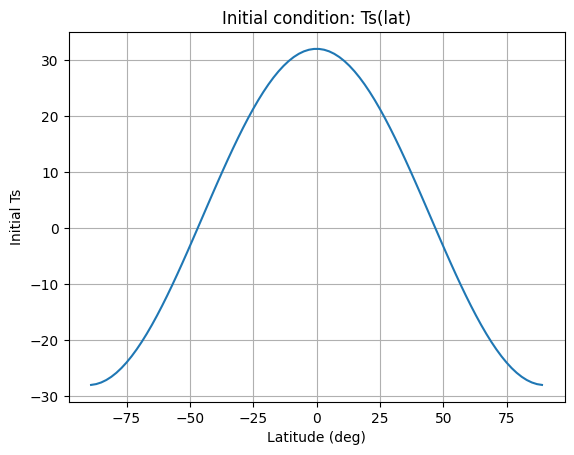

In [21]:
m = climlab.EBM_seasonal()

Ts0 = np.array(m.state['Ts']).ravel()
lat = m.state['Ts'].domain.axes['lat'].points

print("Initial Ts shape:", Ts0.shape)
print("Initial Ts min/max:", Ts0.min(), Ts0.max())
print("First 10 Ts values:", Ts0[:10])

plt.figure()
plt.plot(lat, Ts0)
plt.xlabel("Latitude (deg)")
plt.ylabel("Initial Ts")
plt.title("Initial condition: Ts(lat)")
plt.grid(True)
plt.show()


In [29]:
alb = m.subprocess['albedo']
print(type(alb))
print("Albedo subprocess attributes (subset):")
for name in ['a0', 'ai', 'aice', 'a_land', 'a_ocean', 'Tcrit', 'Tf', 'deltaT', 'param']:
    if hasattr(alb, name):
        print(name, "=", getattr(alb, name))
if hasattr(alb, 'param'):
    print("param keys:", list(alb.param.keys()))


<class 'climlab.surface.albedo.P2Albedo'>
Albedo subprocess attributes (subset):
a0 = 0.33
param = {'timestep': 350632.51200000005, 'a0': 0.33, 'a2': 0.25}
param keys: ['timestep', 'a0', 'a2']


In [30]:
print("State variables:", list(m.state.keys()))
print("Diagnostics:", list(m.diagnostics.keys())[:10], "...")
print("Subprocesses:", list(m.subprocess.keys()))


State variables: ['Ts']
Diagnostics: ['OLR', 'insolation', 'coszen', 'irradiance_factor', 'icelat', 'ice_area', 'albedo', 'ASR', 'diffusive_flux', 'advective_flux'] ...
Subprocesses: ['LW', 'insolation', 'SW', 'diffusion', 'albedo']


In [31]:
# Latitude coordinate
lat = m.state['Ts'].domain.axes['lat'].points

# Time step (seconds -> days)
dt_days = m.timestep / 86400.0
nsteps_year = int(round(365.0 / dt_days))

print(f"Time step: {dt_days:.2f} days")
print(f"Steps per year: {nsteps_year}")

# Store one full seasonal cycle after spin-up
Ts_year = np.zeros((len(lat), nsteps_year))

for k in range(nsteps_year):
    m.step_forward()
    Ts_year[:, k] = np.array(m.state['Ts']).ravel()

# Annual mean temperature profile
Ts_ann = Ts_year.mean(axis=1)

# Time axis for plotting
time_days = np.arange(nsteps_year) * dt_days


Time step: 4.06 days
Steps per year: 90


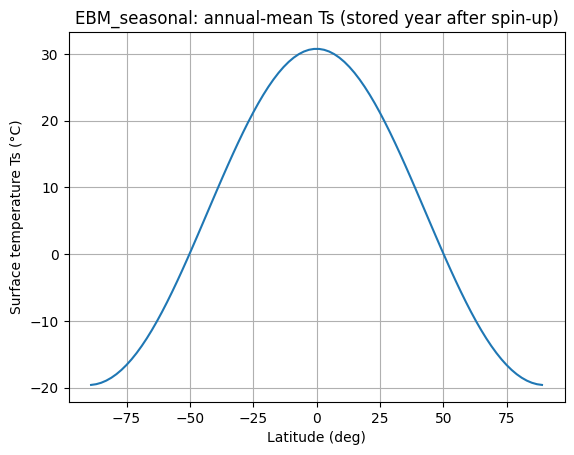

In [32]:
plt.figure()
plt.plot(lat, Ts_ann)
plt.xlabel("Latitude (deg)")
plt.ylabel("Surface temperature Ts (°C)")
plt.title("EBM_seasonal: annual-mean Ts (stored year after spin-up)")
plt.grid(True)
plt.show()


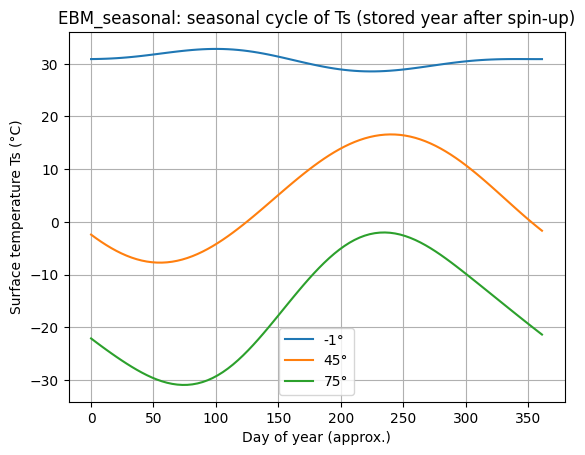

In [33]:
target_lats = [0, 45, 75]
idx = [int(np.argmin(np.abs(lat - x))) for x in target_lats]

plt.figure()
for x, i in zip(target_lats, idx):
    plt.plot(time_days, Ts_year[i, :], label=f"{lat[i]:.0f}°")

plt.xlabel("Day of year (approx.)")
plt.ylabel("Surface temperature Ts (°C)")
plt.title("EBM_seasonal: seasonal cycle of Ts (stored year after spin-up)")
plt.legend()
plt.grid(True)
plt.show()


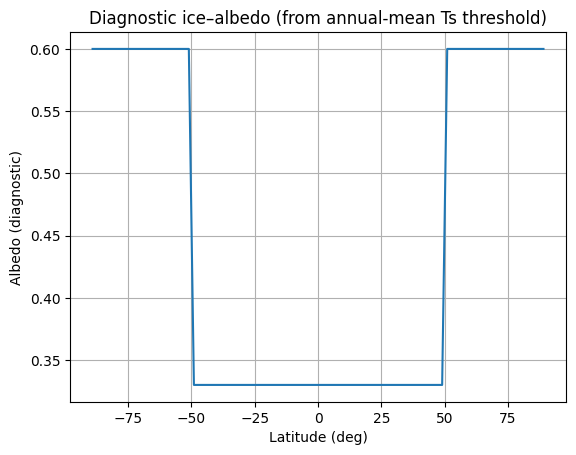

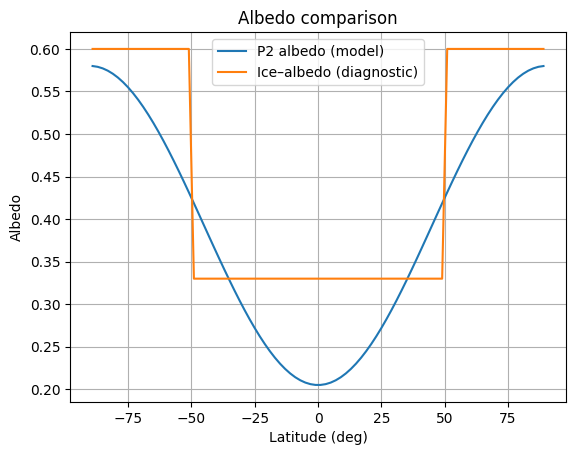

Approx. NH iceline latitude: 51.0°


In [34]:
import matplotlib.pyplot as plt

if ice_albedo_feedback:
    # Diagnostic ice mask from annual-mean temperature
    ice_mask = Ts_ann < Tf

    # Diagnostic two-state albedo
    albedo_ice = np.where(ice_mask, aice, a0)

    plt.figure()
    plt.plot(lat, albedo_ice)
    plt.xlabel("Latitude (deg)")
    plt.ylabel("Albedo (diagnostic)")
    plt.title("Diagnostic ice–albedo (from annual-mean Ts threshold)")
    plt.grid(True)
    plt.show()

    # Compare with smooth P2 albedo used in the model
    x = np.sin(np.deg2rad(lat))
    P2 = 0.5 * (3*x**2 - 1)
    albedo_p2 = a0 + a2 * P2

    plt.figure()
    plt.plot(lat, albedo_p2, label="P2 albedo (model)")
    plt.plot(lat, albedo_ice, label="Ice–albedo (diagnostic)")
    plt.xlabel("Latitude (deg)")
    plt.ylabel("Albedo")
    plt.title("Albedo comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Approximate NH iceline
    nh = lat >= 0
    Ts_nh = Ts_ann[nh]
    lat_nh = lat[nh]
    below = np.where(Ts_nh < Tf)[0]
    if len(below) == 0:
        print("No ice in NH.")
    else:
        print(f"Approx. NH iceline latitude: {lat_nh[below[0]]:.1f}°")


In [8]:
print(getattr(m.state['Ts'], "units", "unknown"))

unknown


Integrating for 1800 steps, 7304.844000000001 days, or 20 years.
Total elapsed time is 19.99999999999943 years.
Integrating for 1800 steps, 7304.844000000001 days, or 20 years.
Total elapsed time is 19.99999999999943 years.


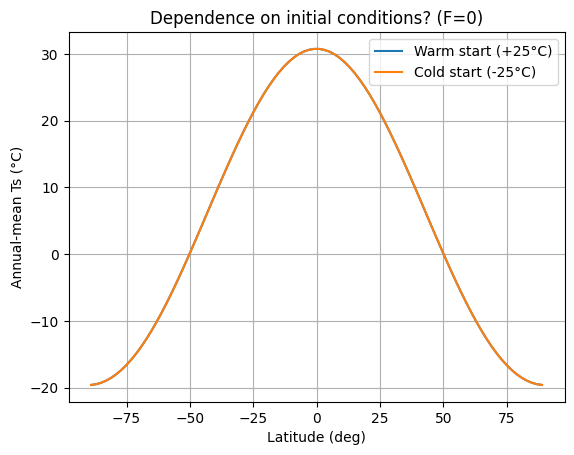

In [9]:
def run_model_with_initial_T(T_init_const, nyears, F):
    m = climlab.EBM_seasonal()

    # forcing: A -> A - F
    A_base = m.param['A']
    A_effective = A_base - F
    m.param['A'] = A_effective
    if 'LW' in m.subprocess:
        lw = m.subprocess['LW']
        if hasattr(lw, 'A'):
            lw.A = A_effective
        elif hasattr(lw, 'param') and 'A' in lw.param:
            lw.param['A'] = A_effective

    # set initial condition
    m.state['Ts'][:] = T_init_const

    # integrate
    m.integrate_years(nyears)

    # return final annual-mean Ts profile (store one year)
    lat = m.state['Ts'].domain.axes['lat'].points
    dt_days = m.timestep / 86400.0
    nsteps_year = int(round(365.0 / dt_days))
    Ts_year = np.zeros((len(lat), nsteps_year))
    for k in range(nsteps_year):
        m.step_forward()
        Ts_year[:, k] = np.array(m.state['Ts']).ravel()
    Ts_ann = Ts_year.mean(axis=1)
    return lat, Ts_ann

lat, Ts_warm = run_model_with_initial_T(25.0, nyears=20, F=0.0)
_,   Ts_cold = run_model_with_initial_T(-25.0, nyears=20, F=0.0)

plt.figure()
plt.plot(lat, Ts_warm, label="Warm start (+25°C)")
plt.plot(lat, Ts_cold, label="Cold start (-25°C)")
plt.xlabel("Latitude (deg)")
plt.ylabel("Annual-mean Ts (°C)")
plt.title("Dependence on initial conditions? (F=0)")
plt.legend()
plt.grid(True)
plt.show()
